# Observe reconstruction fidelity

In [116]:
import VAE_tybalt
from VAE_tybalt import VAE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [118]:
model.load_state_dict(torch.load('vae_weights.pth'))

<All keys matched successfully>

Load data

In [119]:
tcga_tybalt_file_location = 'data/rnaseq_df_test.csv'
rnaseq_df = pd.read_csv(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1,  inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [120]:
rnaseq_df.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.000000,0.676411,0.538535,0.829060,0.371617,0.076709,0.493035,0.495491,0.000000,0.000000,...,0.641401,0.258891,0.520563,0.400908,0.437579,0.560402,0.483713,0.054940,0.333915,0.313550
1,0.000000,0.601335,0.791538,0.580519,0.711329,0.771928,0.557838,0.656916,0.000000,0.000000,...,0.608653,0.157189,0.526314,0.651298,0.422983,0.648942,0.718139,0.030541,0.219439,0.447640
2,0.000000,0.801651,0.515508,0.526579,0.119657,0.212524,0.086728,0.253842,0.000000,0.000000,...,0.278018,0.160775,0.496794,0.384108,0.434125,0.476615,0.634136,0.000000,0.433654,0.308404
3,0.767083,0.132404,0.000000,0.461636,0.000000,0.000000,0.000000,0.046623,0.774512,0.736268,...,0.359250,0.657670,0.340666,0.708832,0.358783,0.328927,0.500310,0.000000,0.224678,0.514864
4,0.022867,0.731514,0.140167,0.749021,0.750316,0.031328,0.000000,0.716501,0.000000,0.000000,...,0.851758,0.450602,0.528139,0.605051,0.601097,0.446412,0.684836,0.074063,0.170475,0.413623


In [121]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = model.forward(torch.tensor(rnaseq_df.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns)

In [122]:
input_rnaseq_reconstruct.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.002521,0.852025,0.626596,0.708038,0.464578,0.314650,0.579852,0.597127,0.001524,0.001207,...,0.609135,0.342641,0.453066,0.465747,0.420225,0.487144,0.630717,0.059178,0.215568,0.316900
1,0.287401,0.372591,0.860924,0.437261,0.425063,0.804569,0.756840,0.510388,0.256333,0.223117,...,0.480395,0.187293,0.583497,0.413583,0.382989,0.559598,0.700044,0.065773,0.334445,0.481161
2,0.055965,0.613258,0.425263,0.470002,0.218997,0.306392,0.254303,0.320074,0.048461,0.049018,...,0.363096,0.359023,0.450932,0.491004,0.368812,0.464423,0.643964,0.048984,0.378466,0.485839
3,0.380641,0.495480,0.215158,0.512902,0.053047,0.095294,0.194783,0.188549,0.415191,0.409081,...,0.523331,0.527918,0.329631,0.575746,0.470667,0.327465,0.538743,0.063934,0.344609,0.679130
4,0.302956,0.353256,0.237893,0.667881,0.598711,0.221139,0.145118,0.700204,0.280808,0.302266,...,0.681855,0.361881,0.480316,0.533465,0.538556,0.392848,0.700475,0.108124,0.245545,0.457715


In [10]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.005413,0.240228
GSTT1,0.017423,0.231286
GSTM1,0.001714,0.221548
DDX3Y,-0.010332,0.216252
EIF1AY,-0.009381,0.213953


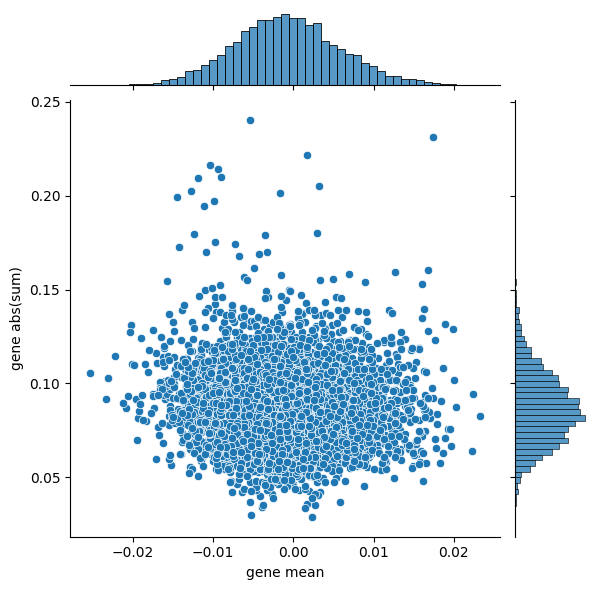

In [123]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

Compute reconstruction losses

In [124]:
BCE_loss = []
KLD_loss = []
MSE_loss = []
# print row vectors next to each other in a loop
for i in range(len(rnaseq_df)):
    x = torch.Tensor(rnaseq_df.iloc[i].values)
    y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
    bce_loss = F.binary_cross_entropy(x, y)
    mse_loss = F.mse_loss(x,y)
    
    #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
    #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))
    
    #kld_loss = torch.sum(kl_divergence(x, prior).item())
    BCE_loss.append(bce_loss)
    MSE_loss.append(mse_loss)
    

Permutation and adding noise

In [63]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled


In [64]:
rnaseq_df.shape[1]

5000

In [84]:
#1 percent of data shuffeled
rnaseq_df_1_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20_shuffle_random = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [217]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_rs = model.forward(torch.tensor(rnaseq_df_1_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_rs = model.forward(torch.tensor(rnaseq_df_3_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_rs = model.forward(torch.tensor(rnaseq_df_5_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_rs = model.forward(torch.tensor(rnaseq_df_8_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_rs = model.forward(torch.tensor(rnaseq_df_10_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10_rs.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_rs = model.forward(torch.tensor(rnaseq_df_20_shuffle_random.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20_rs = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20_rs.detach().numpy(), columns=rnaseq_df.columns)

In [86]:
#compute losses
def compute_losses(rnaseq_df, input_rnaseq_reconstruct):
    BCE_loss = []
    MSE_loss = []
    KLD_loss = []
    for i in range(len(rnaseq_df)):
        x = torch.Tensor(rnaseq_df.iloc[i].values)
        y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
        bce_loss = F.binary_cross_entropy(x, y, reduction='sum')
        mse_loss = F.mse_loss(x,y, reduction='sum')

        #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
        #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

        #kld_loss = torch.sum(kl_divergence(x, prior).item())
        BCE_loss.append(bce_loss.numpy().item())
        MSE_loss.append(mse_loss.numpy().item())
        
    return BCE_loss, MSE_loss

In [87]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0]))

6975.6319288323075
6975.856733333085
7056.851128951997
7058.951451259635
7229.497680430659
8689.448142290572


In [71]:
# Each row is shuffled identically
import pandas as pd
import numpy as np

def shuffle_same_subset_rows(df, subset_size):
    """
    Shuffles the same random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    subset_cols = np.random.choice(num_cols, subset_size, replace=False)
    for i in range(len(df_shuffled)):
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled



In [90]:
#1 percent of data shuffeled
rnaseq_df_1_same_subset = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3_same_subset = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5_same_subset = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8_same_subset = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10_same_subset = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20_same_subset = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [216]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_ss = model.forward(torch.tensor(rnaseq_df_1.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1_ss = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1_ss.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_ss = model.forward(torch.tensor(rnaseq_df_3_same_subset.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3_ss = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3_ss.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_ss = model.forward(torch.tensor(rnaseq_df_5_same_subset.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5_ss = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5_ss.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_ss = model.forward(torch.tensor(rnaseq_df_8_same_subset.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8_ss = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8_ss.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_ss = model.forward(torch.tensor(rnaseq_df_10_same_subset.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10_ss = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10_ss.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_ss = model.forward(torch.tensor(rnaseq_df_20.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20_ss = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20_ss.detach().numpy(), columns=rnaseq_df.columns)

In [137]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0]))

7000.517163132618
6953.2343679978785
7012.364846924295
7089.738853673406
7277.848827821575
8691.693793156406


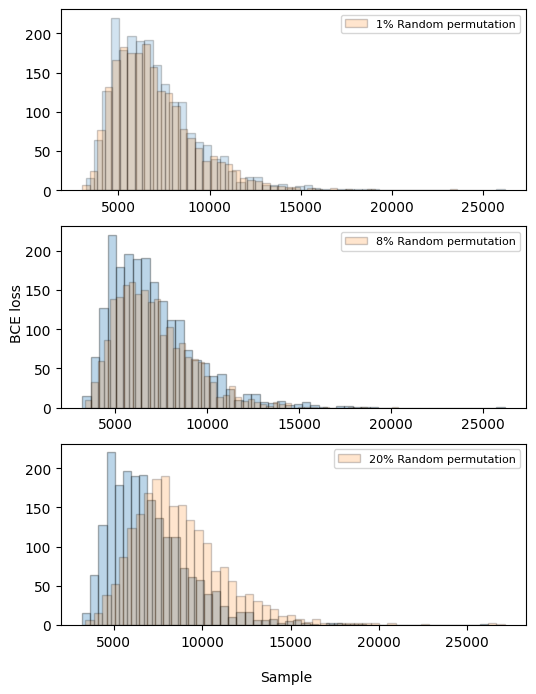

In [158]:
import matplotlib.pyplot as plt
import numpy as np



# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.2)
ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0], bins=50, edgecolor='black', alpha=0.2, label="1% Random permutation")
ax1.legend(fontsize=8)

ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0], bins=50, edgecolor='black', alpha=0.2, label="8% Random permutation")
ax2.legend(fontsize=8)

ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0], bins=50, edgecolor='black', alpha=0.2, label="20% Random permutation")
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, 'Sample', ha='center')
# Add a shared y-axis label
fig.text(0.04, 0.5, 'BCE loss', va='center', rotation='vertical')

# Show the figure
plt.show()


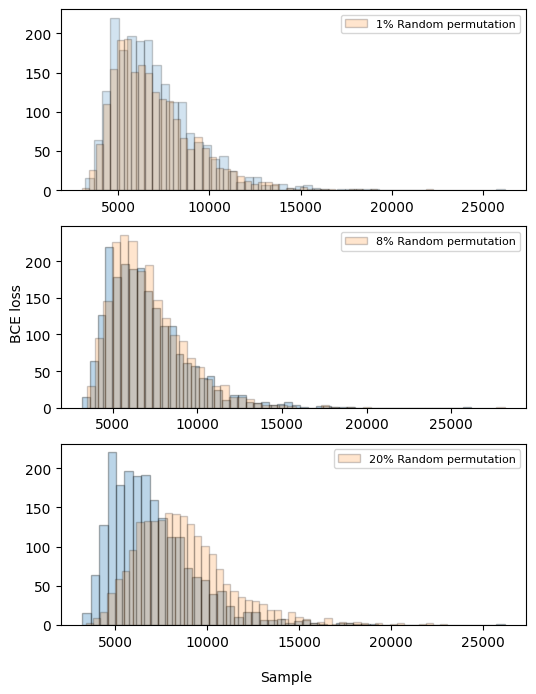

In [160]:
import matplotlib.pyplot as plt
import numpy as np



# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.2)
ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0], bins=50, edgecolor='black', alpha=0.2, label="1% Random permutation")
ax1.legend(fontsize=8)

ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0], bins=50, edgecolor='black', alpha=0.2, label="8% Random permutation")
ax2.legend(fontsize=8)

ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0], bins=50, edgecolor='black', alpha=0.2, label="20% Random permutation")
ax3.legend(fontsize=8)

# Add a shared x-axis label
fig.text(0.5, 0.04, 'Sample', ha='center')
# Add a shared y-axis label
fig.text(0.04, 0.5, 'BCE loss', va='center', rotation='vertical')

# Show the figure
plt.show()

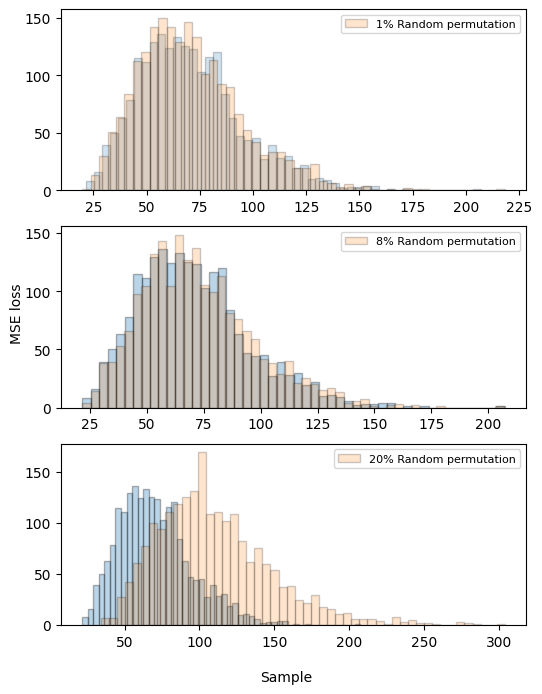

In [162]:
import matplotlib.pyplot as plt
import numpy as np



# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.2)
ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1], bins=50, edgecolor='black', alpha=0.2, label="1% Random permutation")
ax1.legend(fontsize=8)

ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1], bins=50, edgecolor='black', alpha=0.2, label="8% Random permutation")
ax2.legend(fontsize=8)

ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1], bins=50, edgecolor='black', alpha=0.2, label="20% Random permutation")
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, 'Sample', ha='center')
# Add a shared y-axis label
fig.text(0.04, 0.5, 'MSE loss', va='center', rotation='vertical')

# Show the figure
plt.show()


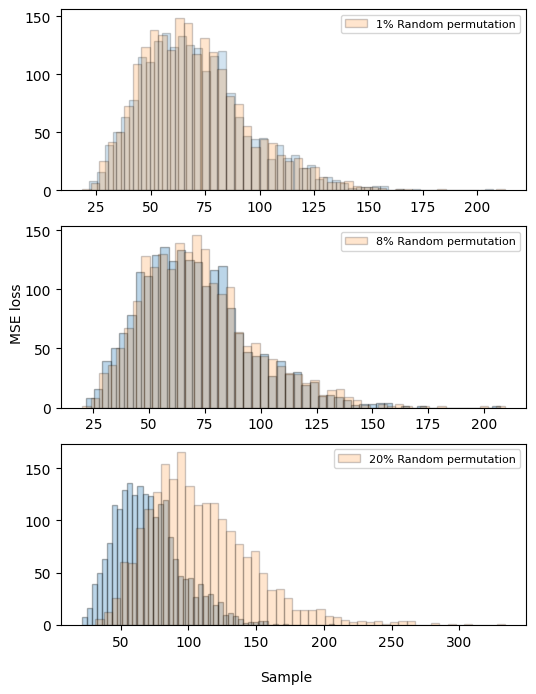

In [164]:
import matplotlib.pyplot as plt
import numpy as np



# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.2)
ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[1], bins=50, edgecolor='black', alpha=0.2, label="1% Random permutation")
ax1.legend(fontsize=8)

ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[1], bins=50, edgecolor='black', alpha=0.2, label="8% Random permutation")
ax2.legend(fontsize=8)

ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[1], bins=50, edgecolor='black', alpha=0.2, label="20% Random permutation")
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, 'Sample', ha='center')
# Add a shared y-axis label
fig.text(0.04, 0.5, 'MSE loss', va='center', rotation='vertical')

# Show the figure
plt.show()


Add Gaussian noise to genes

In [172]:
import pandas as pd
import numpy as np

def add_gaussian_noise(dataframe, mean=0, std_dev=1):
    """
    Adds Gaussian noise to each element of a pandas DataFrame.

    Args:
    dataframe: pandas DataFrame to add noise to.
    mean: Mean of the Gaussian distribution (default: 0)
    std_dev: Standard deviation of the Gaussian distribution (default: 1)

    Returns:
    pandas DataFrame with added Gaussian noise
    """
    noisy_dataframe = dataframe.applymap(lambda x: x + np.random.normal(mean, std_dev))
    return noisy_dataframe


In [168]:
rnaseq_df_noisy_0p1 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.1)
rnaseq_df_noisy_0p3 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.3)
rnaseq_df_noisy_0p6 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.6)
rnaseq_df_noisy_0p9 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.9)

In [169]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p1 = model.forward(torch.tensor(rnaseq_df_noisy_0p1.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_noisy_0p1 = pd.DataFrame(input_rnaseq_reconstruct_tensor_noisy_0p1.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p3 = model.forward(torch.tensor(rnaseq_df_noisy_0p3.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_noisy_0p3 = pd.DataFrame(input_rnaseq_reconstruct_tensor_noisy_0p3.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p6 = model.forward(torch.tensor(rnaseq_df_noisy_0p6.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_noisy_0p6 = pd.DataFrame(input_rnaseq_reconstruct_tensor_noisy_0p6.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p9 = model.forward(torch.tensor(rnaseq_df_noisy_0p9.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_noisy_0p9 = pd.DataFrame(input_rnaseq_reconstruct_tensor_noisy_0p9.detach().numpy(), columns=rnaseq_df.columns)

In [170]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0]))

7000.517163132618
7013.252716589613
7085.376269017761
7329.266280515244
7721.1240523796005


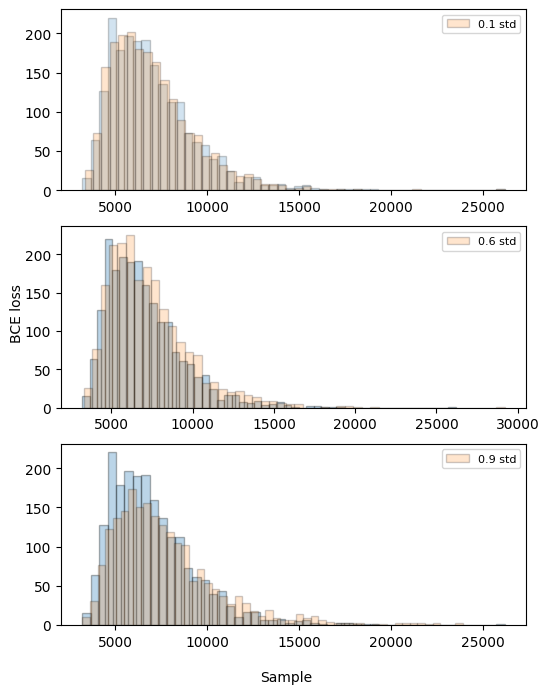

In [176]:
import matplotlib.pyplot as plt
import numpy as np



# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.2)
ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")
ax1.legend(fontsize=8)

ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0], bins=50, edgecolor='black', alpha=0.2, label="0.6 std")
ax2.legend(fontsize=8)

ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.3)
ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0], bins=50, edgecolor='black', alpha=0.2, label="0.9 std")
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, 'Sample', ha='center')
# Add a shared y-axis label
fig.text(0.04, 0.5, 'BCE loss', va='center', rotation='vertical')

# Show the figure
plt.show()


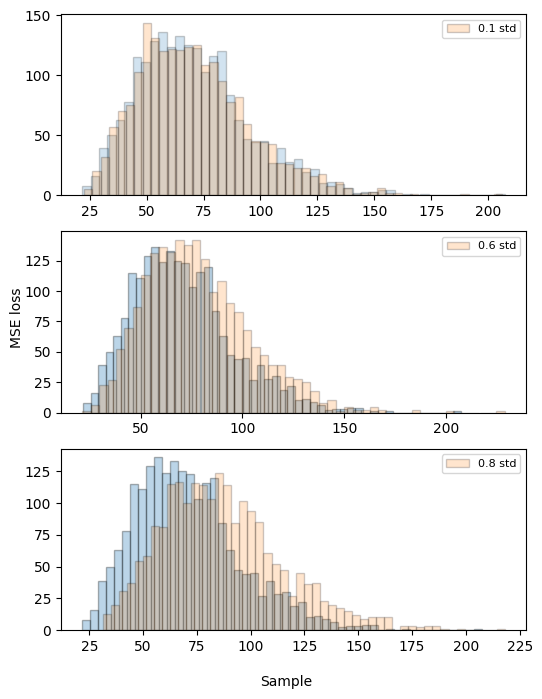

In [178]:
import matplotlib.pyplot as plt
import numpy as np



# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.2)
ax1.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")
ax1.legend(fontsize=8)

ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
ax2.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1], bins=50, edgecolor='black', alpha=0.2, label="0.6 std")
ax2.legend(fontsize=8)

ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.3)
ax3.hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1], bins=50, edgecolor='black', alpha=0.2, label="0.8 std")
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, 'Sample', ha='center')
# Add a shared y-axis label
fig.text(0.04, 0.5, 'MSE loss', va='center', rotation='vertical')

# Show the figure
plt.show()


Compute mean

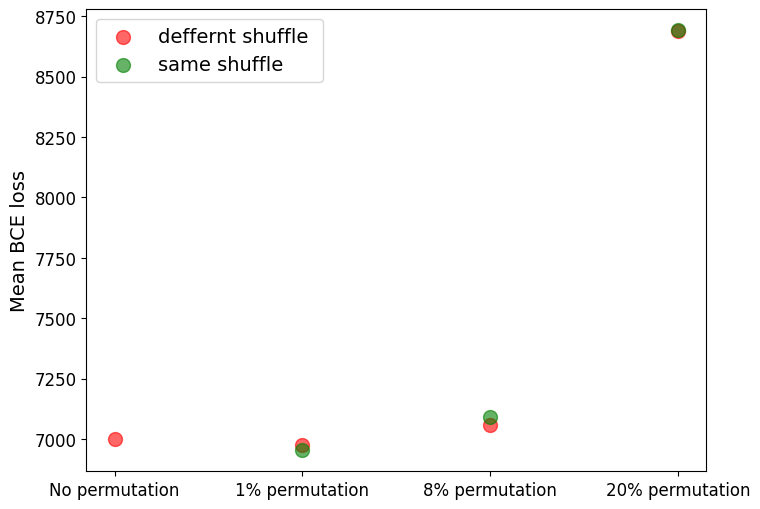

<Figure size 640x480 with 0 Axes>

In [190]:
## compare the performance here
plt.figure(figsize=(8,6))

plt.scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])], c='r', s=100, alpha=.6, label="deffernt shuffle ")
plt.scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0])], c='r', s=100, alpha=.6)
plt.scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0])], c='r', s=100, alpha=.6)
plt.scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0])], c='r', s=100, alpha=.6)


plt.scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0])], c='g', s=100, alpha=.6,label="same shuffle")
plt.scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0])], c='g', s=100, alpha=.6)
plt.scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0])], c='g', s=100, alpha=.6)
plt.legend(fontsize=14)

plt.yticks(fontsize=12)
plt.xticks([0,1,2,3], ['No permutation', '1% permutation', '8% permutation', '20% permutation'], fontsize=12)

plt.ylabel("Mean BCE loss", fontsize=14)
plt.show()
plt.savefig('results/BCE_gene_loss.png')

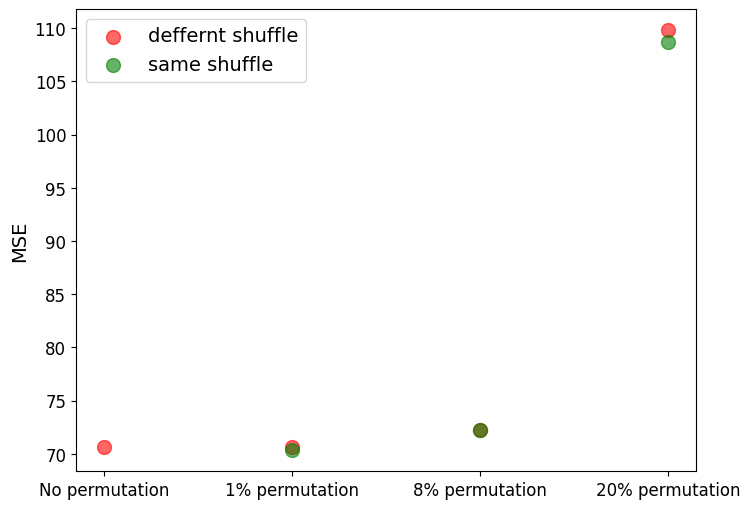

<Figure size 640x480 with 0 Axes>

In [192]:
## compare the performance here
plt.figure(figsize=(8,6))

plt.scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])], c='r', s=100, alpha=.6, label="deffernt shuffle")
plt.scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1])], c='r', s=100, alpha=.6)
plt.scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1])], c='r', s=100, alpha=.6)
plt.scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1])], c='r', s=100, alpha=.6)


plt.scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[1])], c='g', s=100, alpha=.6, label="same shuffle")
plt.scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[1])], c='g', s=100, alpha=.6)
plt.scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[1])], c='g', s=100, alpha=.6)
plt.legend(fontsize=14)

plt.yticks(fontsize=12)
plt.xticks([0,1,2,3], ['No permutation', '1% permutation', '8% permutation', '20% permutation'], fontsize=12)

plt.ylabel("MSE", fontsize=14)
plt.show()
plt.savefig('results/BCE_gene_loss.png')

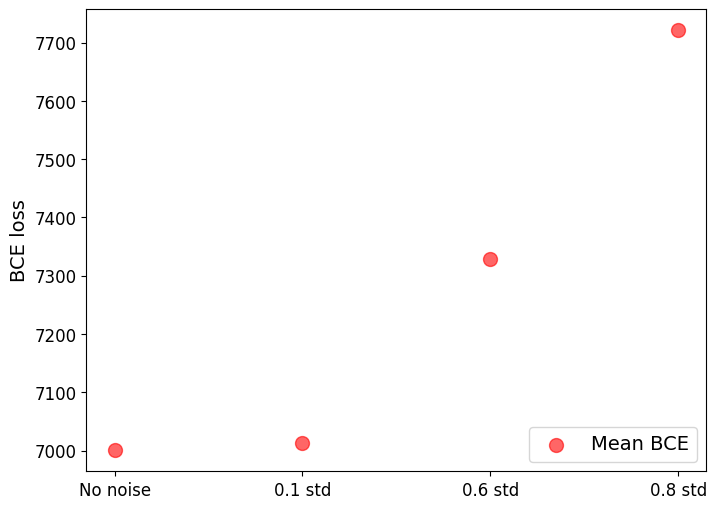

<Figure size 640x480 with 0 Axes>

In [196]:
## compare the performance here
plt.figure(figsize=(8,6))

plt.scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])], c='r', s=100, alpha=.6, label="Mean BCE")
plt.scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0])], c='r', s=100, alpha=.6)
plt.scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0])], c='r', s=100, alpha=.6)
plt.scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0])], c='r', s=100, alpha=.6)


plt.legend(fontsize=14, loc=4)

plt.yticks(fontsize=12)
plt.xticks([0,1,2,3], ['No noise', '0.1 std', '0.6 std', '0.8 std'], fontsize=12)

plt.ylabel("BCE loss", fontsize=14)
plt.show()
plt.savefig('results/BCE_gene_noisy_loss.png')

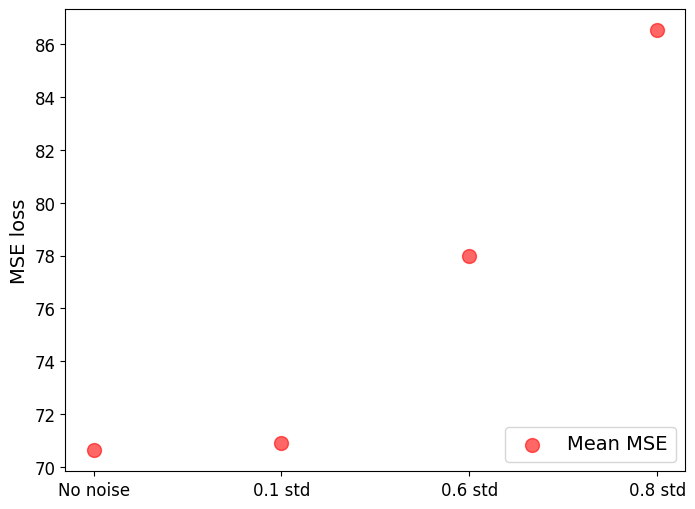

<Figure size 640x480 with 0 Axes>

In [194]:
## compare the performance here
plt.figure(figsize=(8,6))

plt.scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])], c='r', s=100, alpha=.6, label="Mean MSE")
plt.scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1])], c='r', s=100, alpha=.6)
plt.scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1])], c='r', s=100, alpha=.6)
plt.scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1])], c='r', s=100, alpha=.6)


plt.legend(fontsize=14, loc=4)

plt.yticks(fontsize=12)
plt.xticks([0,1,2,3], ['No noise', '0.1 std', '0.6 std', '0.8 std'], fontsize=12)

plt.ylabel("MSE loss", fontsize=14)
plt.show()
plt.savefig('results/MSE_gene_noisy_loss.png')

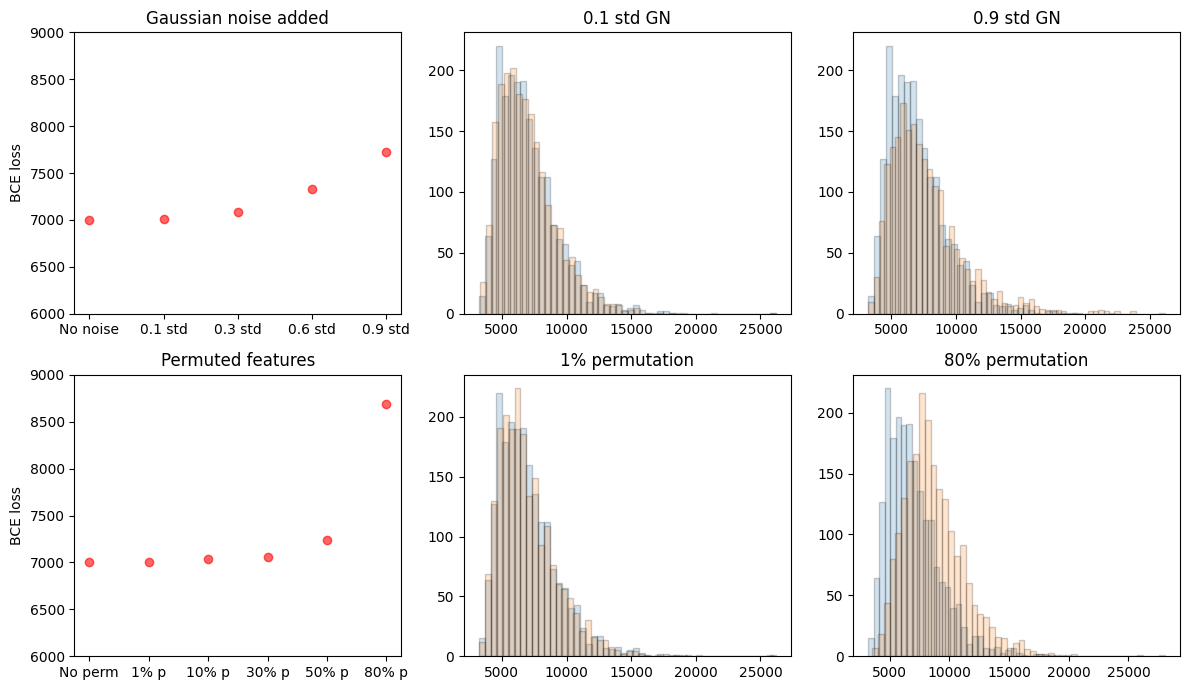

In [245]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

# Plot data on each subplot
axs[0, 0].scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])], c='r', alpha=.6, label="Mean MSE")
axs[0, 0].scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0])], c='r',  alpha=.6)
axs[0, 0].scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[0])], c='r',  alpha=.6)
axs[0, 0].scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0])], c='r', alpha=.6)
axs[0, 0].scatter([4], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0])], c='r',  alpha=.6)

axs[0, 0].set_ylim(6000, 9000)
axs[0, 0].set_ylabel("BCE loss")
axs[0, 0].set_xticks([0,1,2,3,4], ['No noise', '0.1 std', '0.3 std', '0.6 std', '0.9 std'])
axs[0, 0].set_title("Gaussian noise added")

axs[0, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.2)
axs[0, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")

axs[0, 1].set_title("0.1 std GN")
axs[0, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.2)
axs[0, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")
#axs[0, 1].plot(x, y2)
axs[0, 2].set_title("0.9 std GN")
# Plot data on each subplot
axs[1, 0].scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])], c='r', alpha=.6, label="Mean MSE")
axs[1, 0].scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0])], c='r',  alpha=.6)
axs[1, 0].scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[0])], c='r', alpha=.6)
axs[1, 0].scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0])], c='r', alpha=.6)
axs[1, 0].scatter([4], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[0])], c='r', alpha=.6)
axs[1, 0].scatter([5], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0])], c='r',  alpha=.6)
axs[1, 0].set_ylim(6000, 9000)

axs[1, 0].set_ylabel("BCE loss")
axs[1, 0].set_title("Permuted features")
axs[1, 0].set_xticks([0,1,2,3,4,5], ['No perm', '1% p', '10% p', '30% p' , '50% p', '80% p'])

axs[1, 1].set_title("1% permutation")
axs[1, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.2)
axs[1, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")

axs[1, 2].set_title("80% permutation")
axs[1, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0], bins=50, edgecolor='black', alpha=0.2)
axs[1, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")
# Set a tight layout
fig.tight_layout()
plt.savefig('data/Mean_BCE_gene_plots.png')
# Display the plots
plt.show()


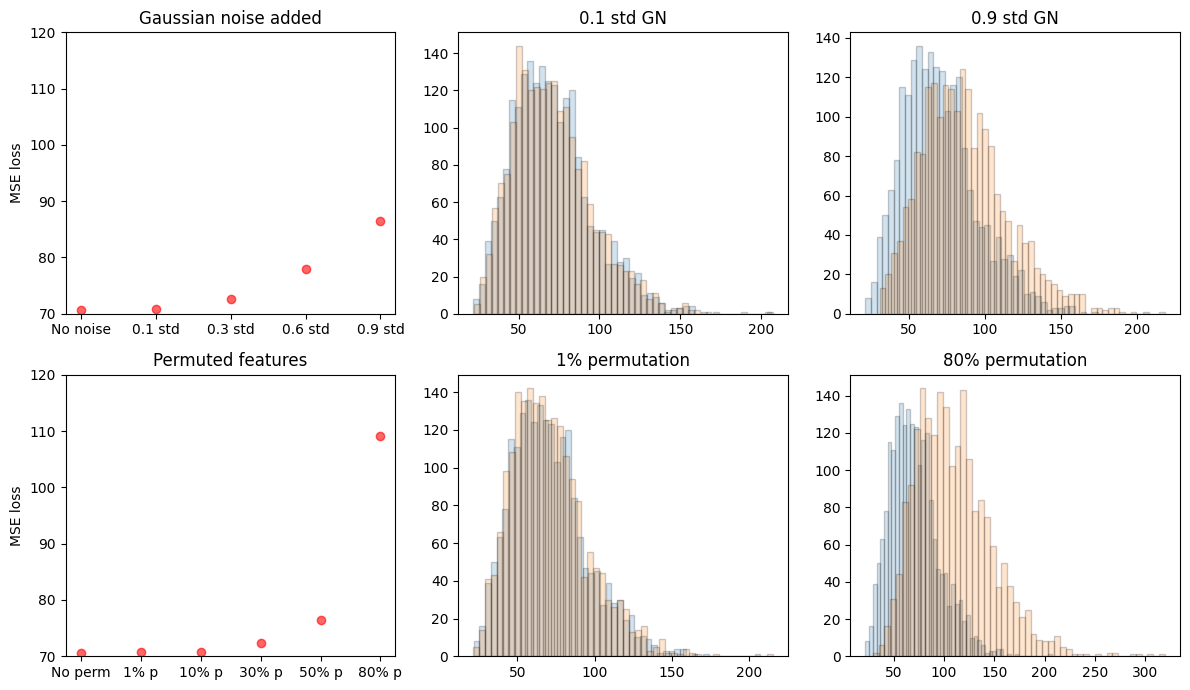

In [246]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

# Plot data on each subplot
axs[0, 0].scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])], c='r', alpha=.6, label="Mean MSE")
axs[0, 0].scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1])], c='r',  alpha=.6)
axs[0, 0].scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[1])], c='r',  alpha=.6)
axs[0, 0].scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1])], c='r', alpha=.6)
axs[0, 0].scatter([4], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1])], c='r',  alpha=.6)

axs[0, 0].set_ylim(70, 120)
axs[0, 0].set_ylabel("MSE loss")
axs[0, 0].set_xticks([0,1,2,3,4], ['No noise', '0.1 std', '0.3 std', '0.6 std', '0.9 std'])
axs[0, 0].set_title("Gaussian noise added")

axs[0, 1].set_title("0.1 std GN")
axs[0, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.2)
axs[0, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")

axs[0, 2].set_title("0.9 std GN")
axs[0, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.2)
axs[0, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")
#axs[0, 1].plot(x, y2)
#axs[0, 2].set_title("Reconstructed with VAE")
# Plot data on each subplot
axs[1, 0].scatter([0], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])], c='r', alpha=.6, label="Mean MSE")
axs[1, 0].scatter([1], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1])], c='r',  alpha=.6)
axs[1, 0].scatter([2], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[1])], c='r', alpha=.6)
axs[1, 0].scatter([3], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1])], c='r', alpha=.6)
axs[1, 0].scatter([4], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[1])], c='r', alpha=.6)
axs[1, 0].scatter([5], [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1])], c='r',  alpha=.6)
axs[1, 0].set_ylim(70, 120)

axs[1, 0].set_ylabel("MSE loss")
axs[1, 0].set_title("Permuted features")
axs[1, 0].set_xticks([0,1,2,3,4,5], ['No perm', '1% p', '10% p', '30% p' , '50% p', '80% p'])

#axs[1, 1].imshow(permuted_img_tensor.detach().view(1, 28, 28).permute(1, 2, 0))
axs[1, 1].set_title("1% permutation")
axs[1, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.2)
axs[1, 1].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")

axs[1, 2].set_title("80% permutation")
axs[1, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1], bins=50, edgecolor='black', alpha=0.2)
axs[1, 2].hist(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1], bins=50, edgecolor='black', alpha=0.2, label="0.1 std")
# Set a tight layout
# Set a tight layout
fig.tight_layout()
plt.savefig('data/Mean_MSE_gene_plots.png')
# Display the plots
plt.show()
